# Probablistic Couterfactual Inference

Chapter nine of the book covers the general algorithm for doing probablistic counterfactual inferencing. The general algorithm consists of three steps:
1.   ***Abduction***
2.   ***Action***
3.   ***Prediction***

**Abduction** deals with *inferring the distribution of the exogenous variables given the factual conditions.*

**Action** deals with *implementing the hypothetical condition as an ideal intervention in the hypothetical world.*

**Prediction** deals with using the *distribution of the exogenous variables to derive the distributions of the hypothetical outcomes.*

Two case studies are used to illustrate the steps of this algorithm using the pyro library. The first one is modeling femur length as a cause of height. The second one deals with semantic editing of generated images.  



## Case Study One

In the first case study we want to model two questions we have regarding femur lengh causing height.

* The first question is a **conditional hypothetical** stated as follows: What would an individual’s height be if their femur length was 46 cm?

* The second question is a **parrallel-world counterfacutal** stated as follows:An individual’s femur is 44 cm, and their height is 165 cm. What would their height be if femur length was 46 cm?

The first question i.e., the **conditional hypothetical** has the following probability distribution: $P(H_{F=46})$; which equates to the probability distribution of a person's height when the *intervention* is done to set the random variable femur length to 46 cm.

The second question i.e., the **parrallel-world counterfacutal** has the following probability distribution: $P(H_{F=46}|F=44, H=165)$; which equates to the probability distribution of a person's height when the *intervention* is done to set the random variable femur length to 46 cm *when in fact the person's femur length is 44 and height is 165 cm.*

In addition to femur length being a cause of height we also add the random variable of sex as a cause of both femur length and height. Accordingly, the subsequent code and sections will implement the **conditional hypothetical** and the **parrallel-world counterfacutal** through **Abduction**, **Action**, and  **Prediction** after converting the Causal DAG (below) into a SCM






### Conditional Hypothetical Graph
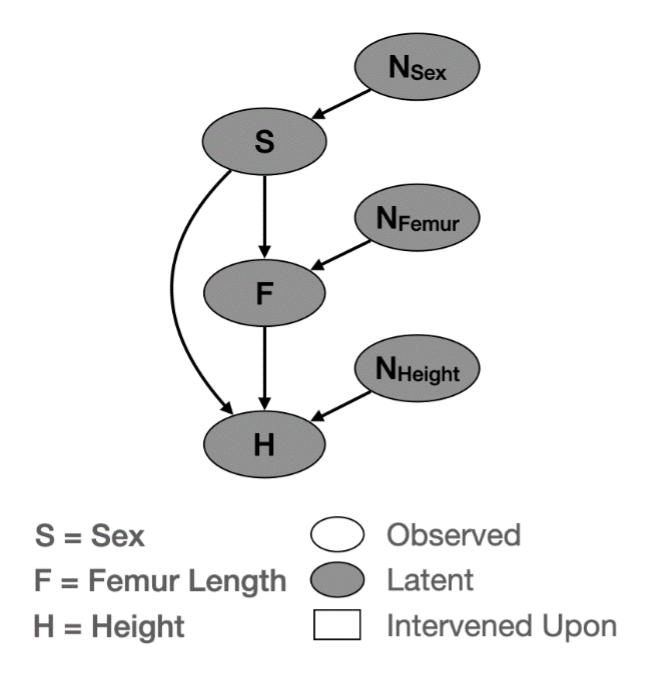


### SCM and Abduction: Conditional Hypothetical Example

As seen from the causal DAG the endogenous variables are Sex, Femur Length, and Height and the exogenous variables are $N_{Sex}$, $N_{Femur}$, $N_{Height}$. Under step 1 of **Abduction** we model the distribution of the exogenous variables given the factual conditions. In this case, the **conditional hypothetical's** probability distribution i.e., $P(H_{F=46})$ does not have factual conditions, so we can model them just using prior distributions. The only cavet here is that in order to use gradient based optimizations such as SGD, Adam, etc, we need to use a distribution/function that is **continuously differentiable** for the endogenous variables i.e., their assignment functions.

Because of this the book uses a pseudo-delta distribution in which a [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution) is transformed to approximate the [Dirac delta distribution](https://en.wikipedia.org/wiki/Dirac_delta_function); which is a debateable "function" that is zero everywhere except at zero!!!😆 This pseudo-delta distribution is used to model the assignment functions for the endogenous variables of Femur Length and Height.


In [ ]:
!pip install pyro-ppl

In [ ]:
from torch import tensor
from pyro.distributions import Bernoulli, Normal
from pyro import sample
from functools import partial

In [ ]:
# exogenous prior distributions
exogenous = {
    'N_sex': Bernoulli(.5),
    'N_femur': Normal(0., 1.),
    'N_height': Normal(0., 1.),
}

# pseudo dirac distribution
PseudoDelta = partial(Normal, scale=.01)

# assignment function: Sex
def f_sex(N_sex):
    return sample("sex", Bernoulli(N_sex))

# assignment function: Femur Length
def f_femur(sex, N_femur):
    if sex == tensor(1.0):
        μ = 43.7 + 2.3 * N_femur
    else:
        μ = 40.238 + 1.9 * N_femur
    return sample("femur", PseudoDelta(μ))

# assignment function: Height
def f_height(femur, sex, N_height):
    if sex == tensor(1.0):
        μ = 61.41 + 2.21 * femur + 7.62 * N_height
    else:
        μ = 54.1 + 2.47 * femur + 7 * N_height
    return sample("height", PseudoDelta(μ))

# SCM model
def model(exogenous):
    N_sex = sample("N_sex", exogenous['N_sex'])
    N_femur = sample("N_femur", exogenous['N_femur'])
    N_height = sample("N_height", exogenous['N_height'])
    sex = f_sex(N_sex)
    femur = f_femur(sex, N_femur)
    height = f_height(femur, sex, N_height)
    return sex, femur, height

### Action and Prediction: Conditional Hypothetical Example

In the **Action** step of probablistic counterfactual inference, *the hypothetical condition is implemented as the ideal intervention in the hypothetical world.* As detailed previously the **conditional hypothetical** has the following probability distribution: $P(H_{F=46})$. Since the distribution has no factual conditions, there is no need to model the hypothetical condition in a hypothetical/parrallel world. The intervention i.e., F=46 will be done using [pyro's do function](https://docs.pyro.ai/en/dev/_modules/pyro/primitives.html#sample) in which the above SCM model and the intervention i.e., F=46, will be passed to it.

Then in the **Prediction** step of probablistic counterfactual inference, the intervened model is repeatedly called using the prior distributions of the exogenous variables to generate/sample values for the endogenous variable Height. We will visualize the **conditional hypothetical** distribution i.e., $P(H_{F=46})$ as a histogram.

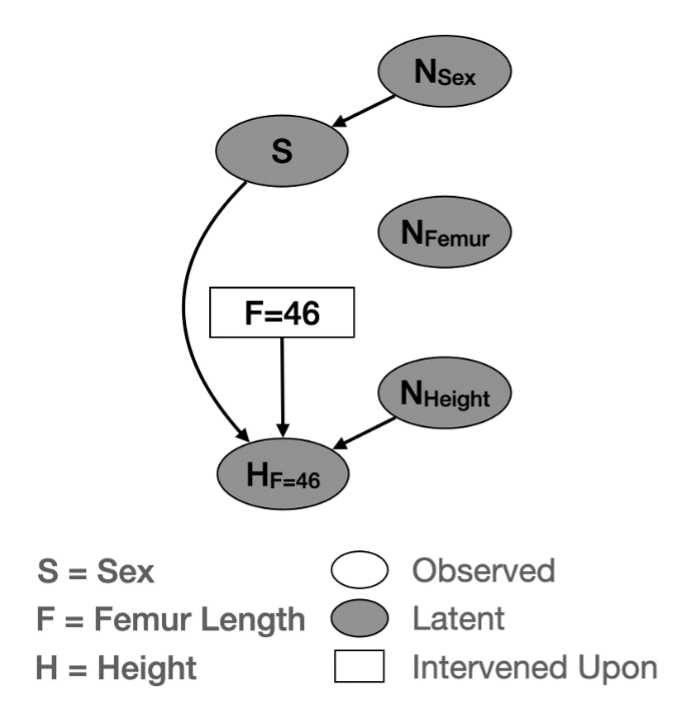

In [ ]:
import matplotlib.pyplot as plt
import pyro

# intervened model: Action step
int_model = pyro.do(model, data={"femur": tensor(46.0)})

# generated/sampled values: Prediction step
int_samples = []
for _ in range(10000):
    _, _, int_height = int_model(exogenous)
    int_samples.append(float(int_height))

# visualizing conditional hypothetical distribution
plt.hist(
    int_samples,
    bins=20,
    alpha=0.5,
    label="Intervention Samples",
    density=True
)
plt.ylim(0., .35)
plt.legend()
plt.xlabel("Height")
plt.show()

### Parrallel-World Counterfacutal Graph
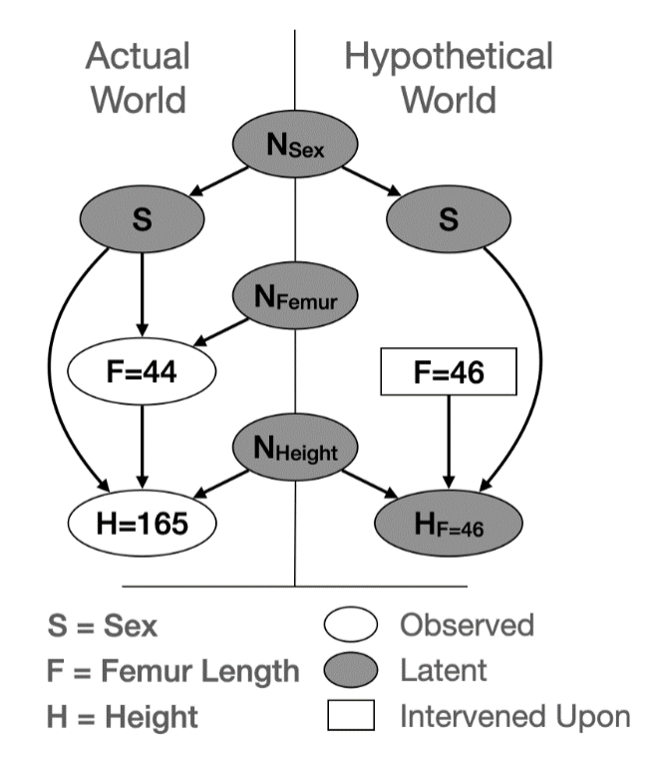

### SCM and Abduction: Parrallel-World Counterfacutal Example

As seen from the parallel world graph above, counterfactual inference deals with **parrallel worlds**. One is the **actual world** which contains the observed values and the other are **parrallel worlds** on which hypothetical interventions are done.

In this case, the **actual world** contains actual values for the observed variables Femur Length i.e.,44 cm and Height i.e., 165 cm for a person. The question we want to model is *what would this person's height be if their Femur Length was 46 cm instead of 44 cm?* Enter **parrallel worlds**

For the conditional hypothetical example the probability distribution we modeled i.e., $P(H_{F=46})$ had no observed values. This is not true for counterfactual inference. As seen above in the parallel world graph the probability distribution we will model takes the following form: $P(H_{F=46}| F=44, H=165)$ Hence the ***Abduction*** step must take these factual values into consideration when inferring the distribution of the exogenous variables.

Instead of modeling $P(N_{Sex}, N_{Femur}, N_{Height})$ we want to model the following target distribution: $P(N_{Sex}, N_{Femur}, N_{Height}|F=44, H=165)$. To do so, we need to use a **guide function** which approximates the target distribution with a **proposal distribution.** As the book states:

> [Variational inference](https://ermongroup.github.io/cs228-notes/inference/variational/) optimizes the **parameters** of **the proposal distribution** such that it becomes close to (or “approximates”) the target distribution

From a code perspective, this is done in four steps:
1.   Specify the guide function
2.   Condition SCM model on observed values
3.   Infer and Optimize paramaters
4.   Update the Posterior Distribution

#### 1.   **Specify the guide function**

To do [Variational inference](https://ermongroup.github.io/cs228-notes/inference/variational/) a **proposal distribution** (as represented by Q) is used to approximate the target distribution i.e., $P(N_{Sex}, N_{Femur}, N_{Height}|F=44, H=165)$. This is done using pyro's [param](https://docs.pyro.ai/en/dev/_modules/pyro/primitives.html) function which contains the parameters of the distribution to be infered and optimized in step 3 and pyro's [sample](https://docs.pyro.ai/en/dev/_modules/pyro/primitives.html) function which samples from the **proposed distribution**

In this case, the exogenous variables $N_{Sex}$ is sampled from a [Bernoulli distribution](https://docs.pyro.ai/en/dev/distributions.html), and  $N_{Femur}$ and $N_{Height}$ are sampled from a [Normal](https://docs.pyro.ai/en/dev/distributions.html) distribution.

#### 2.   **Condition SCM model on observed values**

We will use the previous SCM model (used for the **conditional hypothetical** example) to condition on the observed values of Femur Length i.e.,44 cm and Height i.e., 165 cm. This is done using pyro's [condition](https://docs.pyro.ai/en/dev/poutine.html) function.

#### 3.   **Infer and optimize the paramaters**

The parameters created at step 1 will be inferred through [stochastic variational inference](https://docs.pyro.ai/en/dev/_modules/pyro/infer/svi.html) using the [Trace_Elbo](https://docs.pyro.ai/en/dev/_modules/pyro/infer/trace_elbo.html) loss and [Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimization (the best optimization method in my opinion).

#### 4.   **Update the Posterior Distribution**

In step 4 the optimized parameters from step 3 are extracted and used to update the posterior probability distribution of the exogenous variables i.e., $Q(N_{Sex}, N_{Femur}, N_{Height})$


In [ ]:
# 1. Specify the guide function
import torch.distributions.constraints as constraints
from pyro.primitives import param
#from pyro.distributions import Delta

def guide(exogenous):
    # N_Sex where p =.5
    p = param("p", tensor(.5),constraint=constraints.unit_interval)
    n_sex = sample("N_sex", Bernoulli(p))
    sex = sample("sex", Bernoulli(n_sex))

    # N_Femur where loc=0, scale=1
    n_femur_loc = param("n_femur_loc", tensor(0.0))
    n_femur_scale = param(
        "n_femur_scale",
        tensor(1.0),
        constraint=constraints.positive
    )
    femur_dist = Normal(n_femur_loc, n_femur_scale)
    n_femur = sample("N_femur", femur_dist)

    # N_Height where loc=0, scale=1
    n_height_loc = param("n_height_loc", tensor(0.0))
    n_height_scale = param(
        "n_height_scale",
        tensor(1.0),
        constraint=constraints.positive
    )
    height_dist =  Normal(n_height_loc, n_height_scale)
    n_height = sample("N_height", height_dist)

    # femur = sample("femur", Delta(n_femur))
    # height = sample("height", Delta(n_height))

In [ ]:
# 2. Condition SCM model on observed values
conditioned_model = pyro.condition(
    model,
    data={"femur": tensor(44.0), "height": tensor(165.0)}
)

In [ ]:
# 3. Infer and optimize the paramaters
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.util.set_rng_seed(123)
pyro.clear_param_store()
svi = SVI(
          model=conditioned_model,
          guide=guide,
          optim=Adam({"lr": 0.003}),
          loss=Trace_ELBO()
)

losses = []
num_steps = 5000
for t in range(num_steps):
    losses.append(svi.step(exogenous))

plt.plot(losses)
plt.title("Loss of approx. P(N_sex, N_femur, N_height | F=44, H=165)")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
# 4. Update the posterior distribution
n_sex_p = param("p").item()
n_femur_loc = param("n_femur_loc").item()
n_femur_scale = param("n_femur_scale").item()
n_height_loc = param("n_height_loc").item()
n_height_scale = param("n_height_scale").item()

exogenous_posterior = {
    'N_sex': Bernoulli(n_sex_p),
    'N_femur': Normal(n_femur_loc, n_femur_scale),
    'N_height': Normal(n_height_loc, n_height_scale),
}
exogenous_posterior

### Action and Prediction: Parrallel-World Counterfacutal Example

In the **Action** step the intervention i.e., F=46 is implemented in the **parrallel world.** Pyro's [do](https://pyro4ci.readthedocs.io/en/latest/poutine.html) function is used again setting Femur Length to 46 cm. Then in the **Prediction** step we sample from the counterfactual distribution i.e.,$P(H_{F=46}| F=44, H=165)$ using the paramerters of the exogenous posterior distribution i.e., $Q(N_{Sex}, N_{Femur}, N_{Height})$

In [ ]:
# Action step
int_model = pyro.do(model, data={"femur": tensor(46.0)})
# Prediction step
cf_samples = []
for _ in range(10000):
    _, _, cf_height = int_model(exogenous_posterior)
    cf_samples.append(float(cf_height))

plt.hist(
    cf_samples,
    bins=20,
    alpha=0.5,
    label="Counterfactual Samples",
    density=True
)
plt.ylim(0., .35)
plt.legend()
plt.xlabel("Height")
plt.show()